<h3>House Sales in King County, Washington</h3>
<p>Regression Analysis and Neural Networks with House Sales.
<p>King County is located in Washington State and it contains Washington's major cities like Seattle, Bellevue and Tacoma. The majority of the houses sold here and their residences come from Seattle's suburbs, which provides all the urban living offers but just outside the bustling traffic of Washington's I-5 and expensive house prices. The appeal of living in Washington State is the lack of personal and corporate income tax, this attracts many business here, like Amazon and Microsoft, including many business owners and the rich. </p>
<p> This project will explore the sale price for houses sold in King County. We'll use numerous regression models to compare them and determine the best one. At the end, we'll also implement a neural network on this dataset to see any improvements.

Credited People:
<p>https://www.kaggle.com/burhanykiyakoglu/predicting-house-prices
<p>Burhan Y. Kiyakoglu

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")
import seaborn as sns
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics as metrics

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization

In [2]:
df = pd.read_csv("dataset/kc_house_data.csv")
print(df.shape)
df.head()

(21613, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


<h2>Pt. 1: Data Processing</h2>

In [3]:
print(len(df["date"].unique()))
df["date"].unique()

372


array(['20141013T000000', '20141209T000000', '20150225T000000',
       '20150218T000000', '20140512T000000', '20140627T000000',
       '20150115T000000', '20150415T000000', '20150312T000000',
       '20150403T000000', '20140527T000000', '20140528T000000',
       '20141007T000000', '20150124T000000', '20140731T000000',
       '20140529T000000', '20141205T000000', '20150424T000000',
       '20140514T000000', '20140826T000000', '20140703T000000',
       '20140516T000000', '20141120T000000', '20141103T000000',
       '20140626T000000', '20141201T000000', '20140624T000000',
       '20150302T000000', '20141110T000000', '20141203T000000',
       '20140613T000000', '20141230T000000', '20150213T000000',
       '20140620T000000', '20140715T000000', '20140811T000000',
       '20140707T000000', '20141028T000000', '20140729T000000',
       '20140718T000000', '20150325T000000', '20140716T000000',
       '20150428T000000', '20150311T000000', '20140916T000000',
       '20150217T000000', '20141231T0000

In [4]:
df.drop(["id", "date", "lat", "long"], axis=1, inplace=True)

(17.0, 0.0)

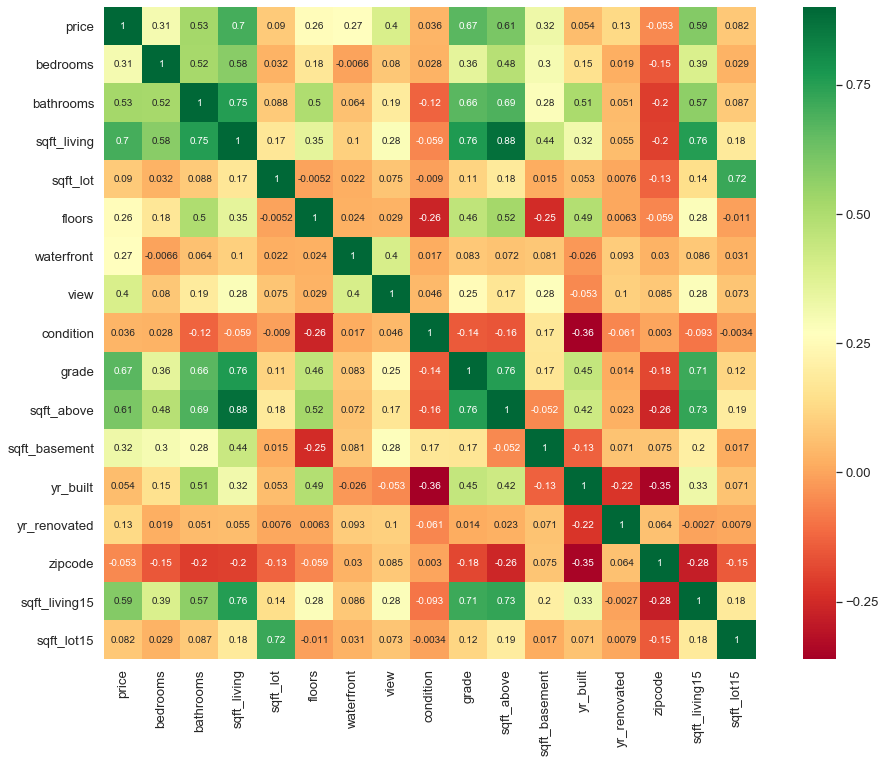

In [5]:
plt.figure(figsize=(17, 12))
sns.set(font_scale=1.2)
sns.heatmap(df.corr(), cbar=True, square=True, vmax=.9, annot_kws={'size': 10}, annot=True, cmap="RdYlGn")

# Fix a bug on the recent version of matplotlib where the bottom and top edges 
# of the seaborn heatmaps are cutoff, creating ugly edges.
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)

# If you want to save the correlation heatmap, you can do so.
# plt.savefig("corrMap.png")

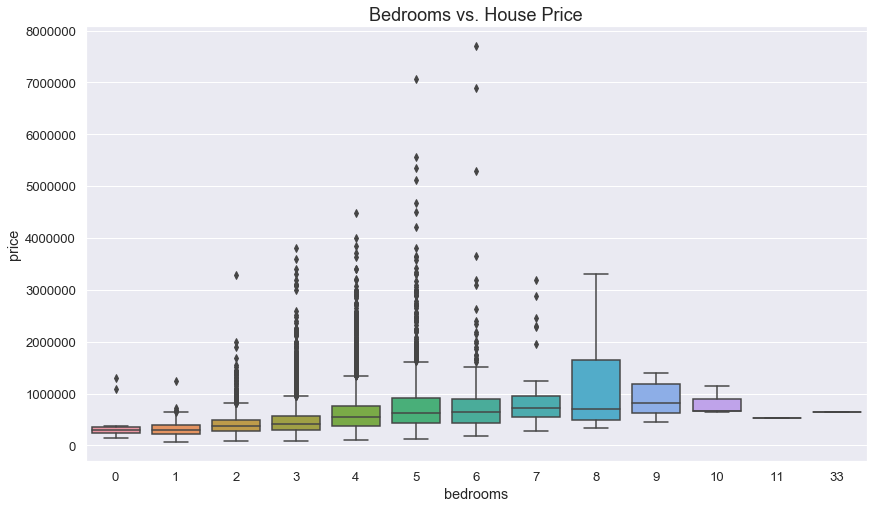

In [6]:
plt.figure(figsize=(14, 8))
plt.title("Bedrooms vs. House Price", fontsize=18)
sns.boxplot(x=df["bedrooms"], y=df["price"])

The bedroom boxplot shows some extreme outliers, like a house with 33 bedrooms. We'll check that house out, including the 11 bedroom house, and see if it can be removed.

In [7]:
df[df["bedrooms"] > 10]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15
8757,520000.0,11,3.00,3000,4960,2.0,0,0,3,7,2400,600,1918,1999,98106,1420,4960
15870,640000.0,33,1.75,1620,6000,1.0,0,0,5,7,1040,580,1947,0,98103,1330,4700


In [8]:
df = df.drop(df[df["bedrooms"] > 10].index).reset_index(drop=True)

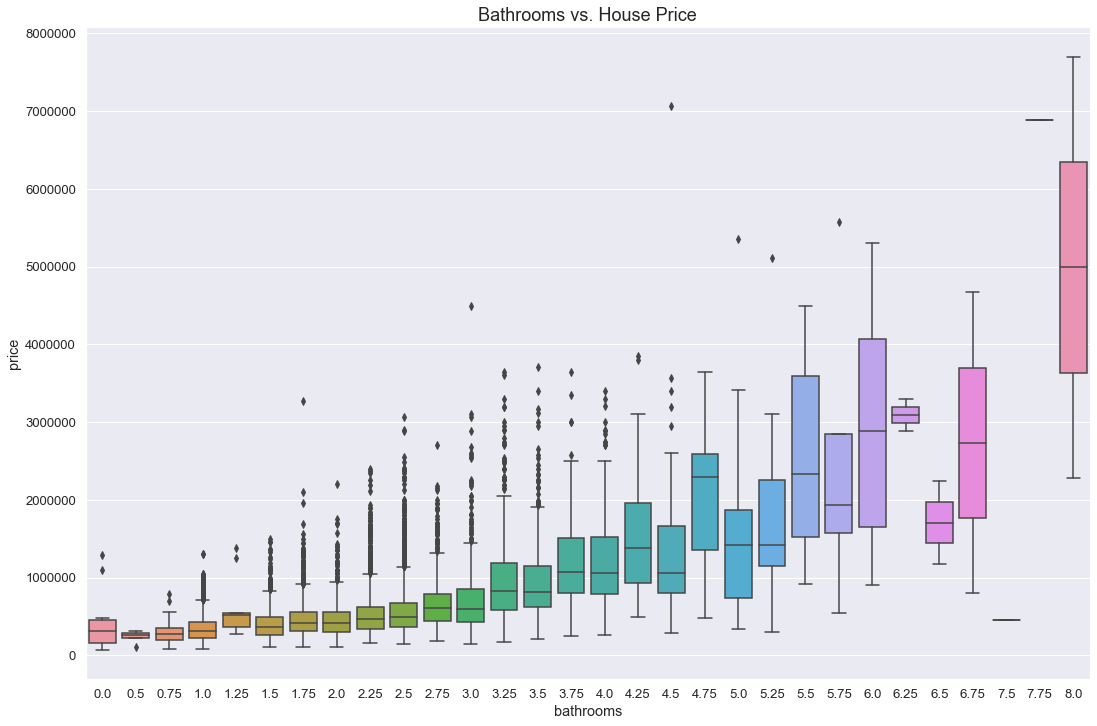

In [9]:
plt.figure(figsize=(18, 12))
plt.title("Bathrooms vs. House Price", fontsize=18)
sns.boxplot(x=df["bathrooms"], y=df["price"])

In [10]:
lbl = LabelEncoder()
lbl.fit(list(df["zipcode"].values))
df["zipcode"] = lbl.transform(list(df["zipcode"].values))

In [11]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,66,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,55,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,16,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,58,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,37,1800,7503


<h2>Pt.2: Machine Learning Analysis Time

In [12]:
X = df.drop("price", axis=1)
y = df["price"]

The feature set values contain a large range of values, from 0 to 6 figure numbers. To make calculations easier, we'll normalize the data.

In [13]:
X = (X - X.mean())/X.std()
X.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15
0,-0.407182,-1.447384,-0.979772,-0.228328,-0.915399,-0.087175,-0.305768,-0.629152,-0.558857,-0.734687,-0.658587,-0.545031,-0.210014,1.603004,-0.943407,-0.260725
1,-0.407182,0.175632,0.533636,-0.189894,0.936479,-0.087175,-0.305768,-0.629152,-0.558857,0.460816,0.245192,-0.681214,4.749061,1.031499,-0.432755,-0.187882
2,-1.510304,-1.447384,-1.426173,-0.123312,-0.915399,-0.087175,-0.305768,-0.629152,-1.409561,-1.229795,-0.658587,-1.294041,-0.210014,-0.994743,1.070023,-0.172391
3,0.695940,1.149441,-0.130522,-0.244020,-0.915399,-0.087175,-0.305768,2.444569,-0.558857,-0.891673,1.397510,-0.204572,-0.210014,1.187364,-0.914227,-0.284530
4,-0.407182,-0.148971,-0.435381,-0.169664,-0.915399,-0.087175,-0.305768,-0.629152,0.291848,-0.130898,-0.658587,0.544438,-0.210014,0.096311,-0.272264,-0.192863


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (17288, 16)
X_test shape: (4323, 16)
y_train shape: (17288,)
y_test shape: (4323,)


<font color="blue"><h3>Linear Regression</h3>

In [15]:
linear_reg = LinearRegression(n_jobs=-1)
linear_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [16]:
y_linear_pred = linear_reg.predict(X_test)

linear_acc = linear_reg.score(X_test, y_test)
print(f"Intercept:     {linear_reg.intercept_}")
print(f"Coefficient Mean: {linear_reg.coef_.mean()}")
print(f"Accuracy:     {linear_acc}")

Intercept:     539693.8699742727
Coefficient Mean: 20401.18773665603
Accuracy:     0.6576931088518757


Let's predict test values and visualize the difference before we formally calulate it using mean errors.

In [17]:
linear_df = pd.DataFrame({"Actual": y_test, "Predicted": y_linear_pred})
linear_df.head()

,Actual,Predicted
4982,476900.0,374663.351291
10254,295000.0,451088.881054
4044,269900.0,374108.304917
21269,320000.0,382586.048637
10494,347500.0,521054.873139


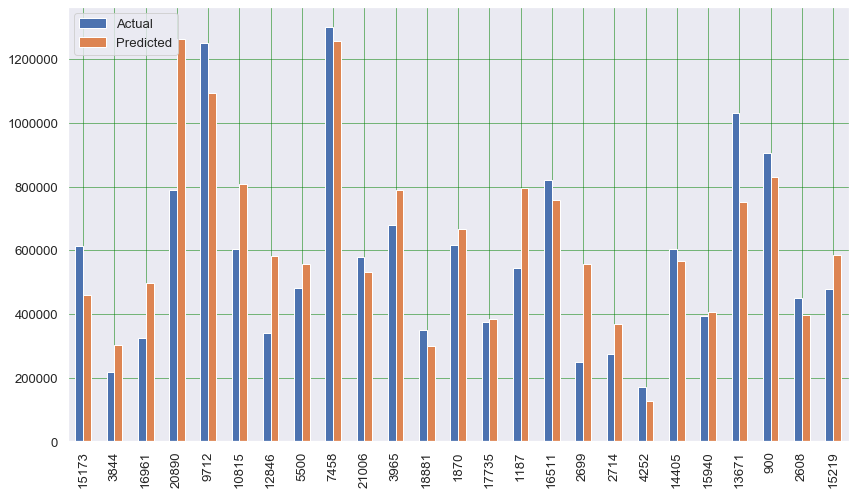

In [18]:
# Plot these predicted test values for 25 of them.
# Example inspired by 
# https://towardsdatascience.com/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-83a8f7ae2b4f

df1 = linear_df.sample(25)
df1.plot(kind="bar", figsize=(14, 8))
plt.legend(loc='upper left')
plt.grid(which="major", linestyle="-", linewidth=0.5, color="green")
plt.grid(which="minor", linestyle=":", linewidth=0.5, color="blue")

The difference between the Actual and Predicted isn't too bad just by looking at the graph. Next we'll calculate the mean absolute error, mean squared error and root mean squared error.

In [19]:
print("Mean Absolute Error:     ${:5.2f}".format( metrics.mean_absolute_error(y_test, y_linear_pred) ))
print("Mean Squared Error:      ${:5.2f}".format( metrics.mean_squared_error(y_test, y_linear_pred)) )
print("Root Mean Squared Error: ${:5.2f}".format( np.sqrt(metrics.mean_squared_error(y_test, y_linear_pred))))

Mean Absolute Error:     $142020.58
Mean Squared Error:      $49466230258.92
Root Mean Squared Error: $222410.05


<font color="blue"><h3>Elastic Net</h3>

In [20]:
elastic_net = ElasticNet(alpha=1, l1_ratio=0.75, max_iter=3000)
elastic_net.fit(X_train, y_train)

ElasticNet(alpha=1, copy_X=True, fit_intercept=True, l1_ratio=0.75,
           max_iter=3000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [21]:
y_elastic_pred = elastic_net.predict(X_test)

elastic_acc = elastic_net.score(X_test, y_test)
print(f"Intercept:     {elastic_net.intercept_}")
print(f"Coefficient Mean: {elastic_net.coef_.mean()}")
print(f"Accuracy:     {elastic_acc}")

Intercept:     539515.3519093494
Coefficient Mean: 22281.873780216243
Accuracy:     0.6389914591063532


In [22]:
elastic_clf = ElasticNet()
elastic_params = {"alpha": [0.25, 0.5, 0.75, 1.0], "l1_ratio": [0.25, 0.35 ,0.5, 0.65, 0.75]}
elastic_grid = GridSearchCV(elastic_clf, elastic_params)
elastic_grid.fit(X_train, y_train)
print(elastic_grid.best_estimator_)

ElasticNet(alpha=0.25, copy_X=True, fit_intercept=True, l1_ratio=0.75,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)


In [23]:
y_elastic_grid_pred = elastic_grid.predict(X_test)

elastic_acc = elastic_grid.score(X_test, y_test)
#print(f"Intercept:     {elastic_grid.intercept_}")
#print(f"Coefficient Mean: {elastic_grid.coef_.mean()}")
print(f"Accuracy: {elastic_acc}")

Accuracy: 0.6544010748361353


Graph of Actual and Predicted value for Elastic Net predictions.

In [24]:
elastic_df = pd.DataFrame({"Actual": y_test, "Predicted": y_elastic_grid_pred})
elastic_df.head()

,Actual,Predicted
4982,476900.0,369490.630936
10254,295000.0,460720.987326
4044,269900.0,376967.150563
21269,320000.0,387175.938834
10494,347500.0,520920.937924


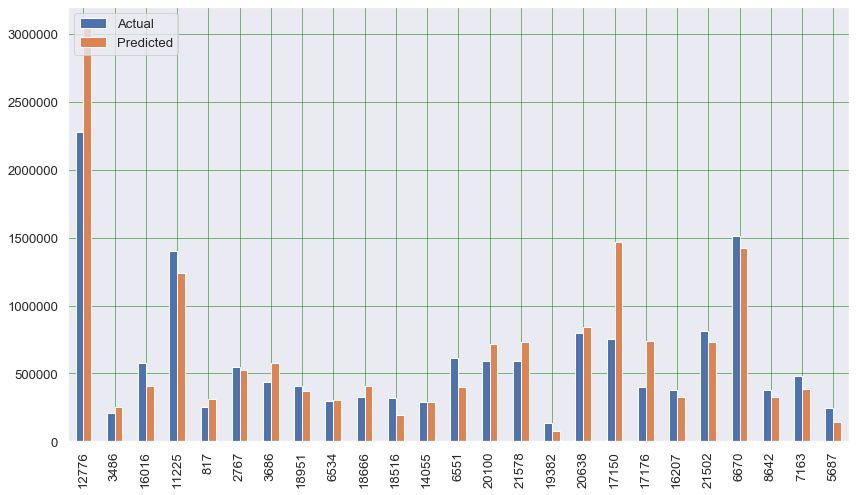

In [25]:
df2 = elastic_df.sample(25)
df2.plot(kind="bar", figsize=(14, 8))
plt.legend(loc='upper left')
plt.grid(which="major", linestyle="-", linewidth=0.5, color="green")
plt.grid(which="minor", linestyle=":", linewidth=0.5, color="blue")

In [26]:
print("Mean Absolute Error:     ${:5.2f}".format( metrics.mean_absolute_error(y_test, y_elastic_grid_pred) ))
print("Mean Squared Error:      ${:5.2f}".format( metrics.mean_squared_error(y_test, y_elastic_grid_pred)) )
print("Root Mean Squared Error: ${:5.2f}".format( np.sqrt(metrics.mean_squared_error(y_test, y_elastic_grid_pred))))

Mean Absolute Error:     $141242.06
Mean Squared Error:      $49941956914.90
Root Mean Squared Error: $223476.97


<font color="blue"><h3>Lasso</h3>

In [27]:
lasso_clf = Lasso(alpha=1)
lasso_clf.fit(X_train, y_train)

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

In [28]:
y_lasso_pred = lasso_clf.predict(X_test)

lasso_acc = lasso_clf.score(X_test, y_test)
print(f"Intercept:     {lasso_clf.intercept_}")
print(f"Coefficient Mean: {lasso_clf.coef_.mean()}")
print(f"Accuracy:     {lasso_acc}")

Intercept:     539693.8835833606
Coefficient Mean: 15816.092308947918
Accuracy:     0.6576937809135257


In [29]:
lasso_df = pd.DataFrame({"Actual": y_test, "Predicted": y_lasso_pred})
lasso_df.head()

,Actual,Predicted
4982,476900.0,374661.153650
10254,295000.0,451088.282671
4044,269900.0,374106.333128
21269,320000.0,382579.912259
10494,347500.0,521048.971620


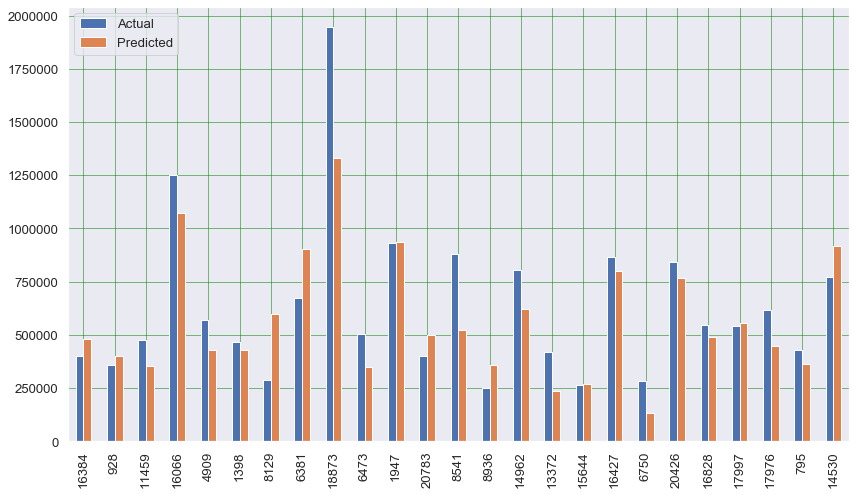

In [30]:
df3 = lasso_df.sample(25)
df3.plot(kind="bar", figsize=(14, 8))
plt.legend(loc='upper left')
plt.grid(which="major", linestyle="-", linewidth=0.5, color="green")
plt.grid(which="minor", linestyle=":", linewidth=0.5, color="blue")

In [31]:
print("Mean Absolute Error:     ${:5.2f}".format( metrics.mean_absolute_error(y_test, y_lasso_pred) ))
print("Mean Squared Error:      ${:5.2f}".format( metrics.mean_squared_error(y_test, y_lasso_pred)) )
print("Root Mean Squared Error: ${:5.2f}".format( np.sqrt(metrics.mean_squared_error(y_test, y_lasso_pred))))

Mean Absolute Error:     $142020.50
Mean Squared Error:      $49466133140.35
Root Mean Squared Error: $222409.83


<font color="blue"><h3>Random Forest Regressor</h3>

In [32]:
rf_reg = RandomForestRegressor(n_jobs=-1)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [33]:
y_rf_pred = rf_reg.predict(X_test)

rf_acc = rf_reg.score(X_test, y_test)
print(f"Accuracy: {rf_acc}")

Accuracy: 0.7790491074977853


In [34]:
rf_params = {"min_samples_split": [4, 8, 12, 16], "n_estimators": [25, 50, 75, 100], "n_jobs": [-1]}
rf_grid_reg = RandomForestRegressor()
rf_grid = GridSearchCV(rf_grid_reg, rf_params)
rf_grid.fit(X_train, y_train)
print(rf_grid.best_estimator_)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)


In [35]:
rf_grids = RandomForestRegressor(min_samples_split=12, n_estimators=75, n_jobs=-1, random_state=42)
rf_grids.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=12,
                      min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [36]:
y_rf_grid_pred = rf_reg.predict(X_test)

rf_acc = rf_grids.score(X_test, y_test)
print(f"Accuracy: {rf_acc}")

Accuracy: 0.7975616989353899


In [37]:
rf_df = pd.DataFrame({"Actual": y_test, "Predicted": y_rf_grid_pred})
rf_df.head()

,Actual,Predicted
4982,476900.0,399413.333333
10254,295000.0,331958.300000
4044,269900.0,343545.000000
21269,320000.0,472399.900000
10494,347500.0,312970.000000


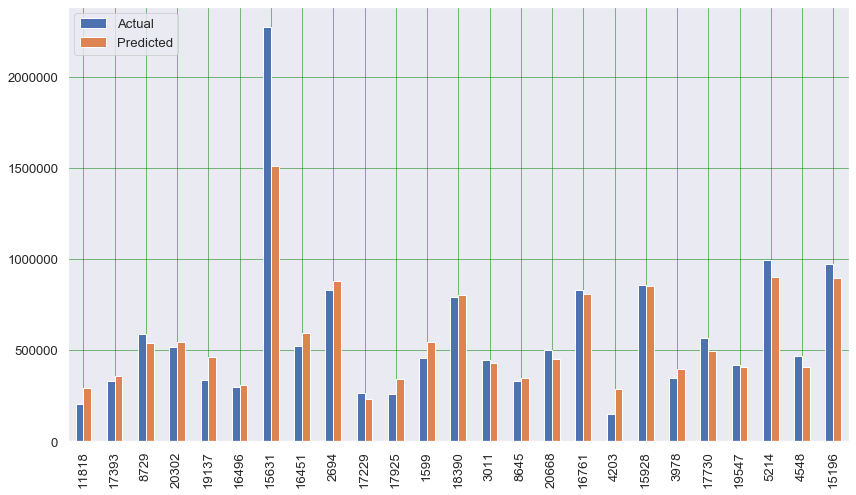

In [38]:
df4 = rf_df.sample(25)
df4.plot(kind="bar", figsize=(14, 8))
plt.legend(loc='upper left')
plt.grid(which="major", linestyle="-", linewidth=0.5, color="green")
plt.grid(which="minor", linestyle=":", linewidth=0.5, color="blue")

In [39]:
print("Mean Absolute Error:     ${:5.2f}".format( metrics.mean_absolute_error(y_test, y_rf_grid_pred) ))
print("Mean Squared Error:      ${:5.2f}".format( metrics.mean_squared_error(y_test, y_rf_grid_pred)) )
print("Root Mean Squared Error: ${:5.2f}".format( np.sqrt(metrics.mean_squared_error(y_test, y_rf_grid_pred))))

Mean Absolute Error:     $95695.20
Mean Squared Error:      $31929265834.44
Root Mean Squared Error: $178687.62


The Random Forest Regressor is the better of the 4 regression models we have implemented. We'll implement a tensorflow neural network for the last model to compare how well this does.

In [40]:
model = Sequential()

# Input layer
model.add(Dense(64, input_shape=[X_train.shape[1]]))
model.add(Activation("relu"))

# Hidden Layer 1
model.add(Dense(128))
model.add(Activation("relu"))
model.add(Dropout(0.05))

# Hidden Layer 2
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.10))

# Hidden Layer 3
model.add(Dense(32))
model.add(Activation("relu"))
model.add(Dropout(0.025))

# Hidden Layer 4
model.add(Dense(32))
model.add(Activation("relu"))
model.add(Dropout(0.025))

# Output layer
model.add(Dense(1))

In [42]:
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss="mse", optimizer=optimizer, metrics=["mae", "mse"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1088      
_________________________________________________________________
activation (Activation)      (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
activation_2 (Activation)    (None, 64)                0

In [43]:
EPOCHS = 200

model_history = model.fit(X_train, y_train, epochs=EPOCHS, validation_split=0.2, batch_size=196, verbose=1)

Train on 13830 samples, validate on 3458 samples
Epoch 1/200
13830/13830 [==============================] - 1s 78us/sample - loss: 426402874405.4652 - mae: 539479.7500 - mse: 426402873344.0000 - val_loss: 405206481551.0283 - val_mae: 533957.6875 - val_mse: 405206433792.0000
Epoch 2/200
13830/13830 [==============================] - 0s 30us/sample - loss: 406300443351.3880 - mae: 525079.1875 - mse: 406300327936.0000 - val_loss: 318469141126.7368 - val_mae: 469407.8438 - val_mse: 318469177344.0000
Epoch 3/200
13830/13830 [==============================] - 0s 25us/sample - loss: 158597137793.7585 - mae: 294527.0625 - mse: 158597136384.0000 - val_loss: 73048347337.0688 - val_mae: 201283.8906 - val_mse: 73048350720.0000
Epoch 4/200
13830/13830 [==============================] - 0s 26us/sample - loss: 74801792100.2528 - mae: 195282.6719 - mse: 74801807360.0000 - val_loss: 60860742386.5263 - val_mae: 179243.4062 - val_mse: 60860743680.0000
Epoch 5/200
13830/13830 [============================

Epoch 37/200
13830/13830 [==============================] - 0s 24us/sample - loss: 39624822793.7735 - mae: 131705.7656 - mse: 39624818688.0000 - val_loss: 34330980020.3401 - val_mae: 125612.1562 - val_mse: 34330980352.0000
Epoch 38/200
13830/13830 [==============================] - 0s 24us/sample - loss: 39532812447.0421 - mae: 131434.0625 - mse: 39532814336.0000 - val_loss: 34364962509.2146 - val_mae: 125055.2266 - val_mse: 34364960768.0000
Epoch 39/200
13830/13830 [==============================] - 0s 29us/sample - loss: 40101296890.6320 - mae: 132069.3281 - mse: 40101298176.0000 - val_loss: 34140135556.6640 - val_mae: 126057.0234 - val_mse: 34140135424.0000
Epoch 40/200
13830/13830 [==============================] - 0s 24us/sample - loss: 38769626387.2879 - mae: 131376.4219 - mse: 38769618944.0000 - val_loss: 34123696517.7004 - val_mae: 124971.4375 - val_mse: 34123696128.0000
Epoch 41/200
13830/13830 [==============================] - 0s 26us/sample - loss: 39260914537.3987 - mae: 1

Epoch 74/200
13830/13830 [==============================] - 0s 28us/sample - loss: 36402416760.0960 - mae: 126567.5234 - mse: 36402413568.0000 - val_loss: 31971898098.5263 - val_mae: 121881.2500 - val_mse: 31971901440.0000
Epoch 75/200
13830/13830 [==============================] - 0s 23us/sample - loss: 35511830599.6726 - mae: 126322.9766 - mse: 35511832576.0000 - val_loss: 32723164711.3846 - val_mae: 120468.6953 - val_mse: 32723161088.0000
Epoch 76/200
13830/13830 [==============================] - 0s 23us/sample - loss: 36567213726.6719 - mae: 126513.7578 - mse: 36567216128.0000 - val_loss: 31777103457.4251 - val_mae: 120668.2812 - val_mse: 31777103872.0000
Epoch 77/200
13830/13830 [==============================] - 0s 28us/sample - loss: 35419373342.6163 - mae: 125723.1484 - mse: 35419377664.0000 - val_loss: 31806423603.8219 - val_mae: 120417.2578 - val_mse: 31806425088.0000
Epoch 78/200
13830/13830 [==============================] - 0s 24us/sample - loss: 35984164287.9537 - mae: 1

Epoch 111/200
13830/13830 [==============================] - 0s 24us/sample - loss: 34038815100.2794 - mae: 123049.1172 - mse: 34038814720.0000 - val_loss: 30502321985.2955 - val_mae: 117475.8125 - val_mse: 30502324224.0000
Epoch 112/200
13830/13830 [==============================] - 0s 29us/sample - loss: 33266059667.0843 - mae: 122147.6953 - mse: 33266063360.0000 - val_loss: 30392776040.6802 - val_mae: 117860.0625 - val_mse: 30392772608.0000
Epoch 113/200
13830/13830 [==============================] - 0s 26us/sample - loss: 33452941016.1284 - mae: 122569.0391 - mse: 33452933120.0000 - val_loss: 30479107391.2227 - val_mae: 117792.5000 - val_mse: 30479108096.0000
Epoch 114/200
13830/13830 [==============================] - 0s 24us/sample - loss: 33474303039.2318 - mae: 122635.2422 - mse: 33474299904.0000 - val_loss: 30628602834.3968 - val_mae: 117190.0625 - val_mse: 30628599808.0000
Epoch 115/200
13830/13830 [==============================] - 0s 28us/sample - loss: 33268183312.4743 - m

13830/13830 [==============================] - 0s 30us/sample - loss: 32572267344.8168 - mae: 121065.7656 - mse: 32572266496.0000 - val_loss: 30020414393.5223 - val_mae: 115962.9453 - val_mse: 30020411392.0000
Epoch 148/200
13830/13830 [==============================] - 0s 24us/sample - loss: 32113769365.5277 - mae: 120232.8984 - mse: 32113768448.0000 - val_loss: 30000127054.7692 - val_mae: 116337.1641 - val_mse: 30000130048.0000
Epoch 149/200
13830/13830 [==============================] - 0s 24us/sample - loss: 31430794743.0409 - mae: 119389.2812 - mse: 31430791168.0000 - val_loss: 29999364054.5425 - val_mae: 116295.7266 - val_mse: 29999368192.0000
Epoch 150/200
13830/13830 [==============================] - 0s 29us/sample - loss: 32032524005.7521 - mae: 120222.0234 - mse: 32032518144.0000 - val_loss: 29934042016.6478 - val_mae: 116159.9922 - val_mse: 29934039040.0000
Epoch 151/200
13830/13830 [==============================] - 0s 24us/sample - loss: 31653363774.1952 - mae: 119232.390

Epoch 184/200
13830/13830 [==============================] - 0s 24us/sample - loss: 31754053888.1851 - mae: 118683.3125 - mse: 31754055680.0000 - val_loss: 29629679931.0769 - val_mae: 114796.8906 - val_mse: 29629681664.0000
Epoch 185/200
13830/13830 [==============================] - 0s 28us/sample - loss: 30957507544.1654 - mae: 117798.2812 - mse: 30957508608.0000 - val_loss: 29627935126.2834 - val_mae: 114066.2031 - val_mse: 29627936768.0000
Epoch 186/200
13830/13830 [==============================] - 0s 24us/sample - loss: 30820896730.3867 - mae: 117593.2734 - mse: 30820896768.0000 - val_loss: 29916461503.7409 - val_mae: 115251.1562 - val_mse: 29916459008.0000
Epoch 187/200
13830/13830 [==============================] - 0s 24us/sample - loss: 31272827497.5098 - mae: 118149.7266 - mse: 31272822784.0000 - val_loss: 29647389360.1943 - val_mae: 113962.3906 - val_mse: 29647388672.0000
Epoch 188/200
13830/13830 [==============================] - 0s 28us/sample - loss: 31055154048.2036 - m

In [44]:
loss1, mae1, mse1 = model.evaluate(X_test, y_test, verbose=2)
print("Testing set Mean Abs Error: ${:5.2f}".format(mae1))

4323/4323 - 0s - loss: 32848822088.7199 - mae: 116328.6953 - mse: 32848822272.0000
Testing set Mean Abs Error: $116328.70


Mean Absolute Error with different optimizer hyperparameters:
<li>Adam(learning_rate=0.001): \$119,584.63</li>
<li>Adam(learning_rate=0.01):  \$119,966.11</li>
<li>Adam(learning_rate=0.1):   \$119,651.23</li>
<p></p>
<li>SGD(learning_rate=0.01): \$120,280.39</li>

The model history will now be plotted to observe the mean error.

In [45]:
hist = pd.DataFrame(model_history.history)
hist['epoch'] = model_history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
195,3.049606e+10,117209.242188,3.049606e+10,2.967976e+10,113980.953125,2.967976e+10,195
196,3.073099e+10,117838.226562,3.073099e+10,2.960250e+10,113959.578125,2.960250e+10,196
197,3.062660e+10,117517.664062,3.062660e+10,2.956075e+10,113526.757812,2.956075e+10,197
198,3.115005e+10,117221.632812,3.115005e+10,2.960016e+10,113927.914062,2.960016e+10,198
199,3.079267e+10,116673.703125,3.079267e+10,2.976263e+10,114206.406250,2.976263e+10,199


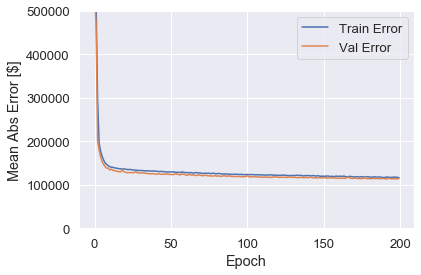

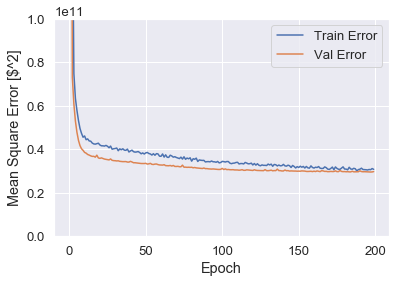

In [48]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [$]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label='Val Error')
    plt.ylim([0,500000])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$^2]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label='Val Error')
    plt.ylim([0,1e11])
    plt.legend()
    plt.show()

plot_history(model_history)

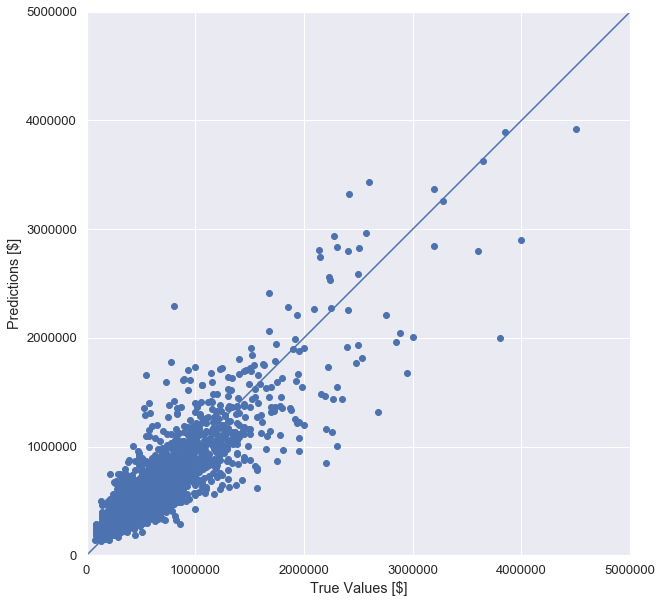

In [47]:
nn_preds = model.predict(X_test).flatten()

plt.figure(figsize=(15, 10))
plt.axes(aspect='equal')
plt.scatter(y_test, nn_preds)
plt.xlabel('True Values [$]')
plt.ylabel('Predictions [$]')
lims = [0, 5000000]
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims)

<h2>Overview</h2>
<p>The Neural Network model has predicted a lot of houses in the lower bracket (\$50k - \$200k), but overall, there are quite a few outliers in the model far away from the r-squared line.
<p>Of the algorithms tried, the Random Forest algorithm is the best estimator for the dataset with a mean absolute error of below \$100,000. If given more information on each house, like the square footage of outdoor space, material of the driveway, or floor material, a better estimator might be achieved. 